# Frozen Lake with Q-learning

In [12]:
import gym
import numpy as np
import matplotlib.pyplot as plt
from gym.envs.registration import register

register(
    id='FrozenLake-v3',
    entry_point='gym.envs.toy_text:FrozenLakeEnv',
    kwargs={'map_name': '4x4',
            'is_slippery':False}
            )
env = gym.make('FrozenLake-v3')

#Initialize table with all zeros
Q = np.zeros([env.observation_space.n,env.action_space.n])

#Discount Factor (lambda)
dis = .55
num_episodes = 2000

#create lists to contain total rewards and steps per sepisode
rList = []

for i in range(num_episodes):
    #Reset environment and get first new observation
    state = env.reset()
    rAll =0
    done = False

    #Q-table learning algorithm
    while not done:
        # Choose an action by greddily (with noise) picking from Q table
        action = np.argmax(Q[state[0],:]+np.random.randn(1,env.action_space.n) / (i+1))

        #get new state and reward from environment
        new_state,reward,done,_,prob=env.step(action)

        #update Q-table with new knowledge using decay rate
        Q[state[0],action] = reward + dis * np.max(Q[new_state,:])

        rAll += reward
        state = (new_state,prob)
    
    rList.append(rAll)


Success rate:0.9525
final Q-Table Values
[[0.         0.05032844 0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.09150625 0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.09150625 0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.166375   0.        ]
 [0.         0.3025     0.         0.        ]
 [0.166375   0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.55       0.        ]
 [0.         0.         1.         0.        ]
 [0.         0.         0.         0.        ]]


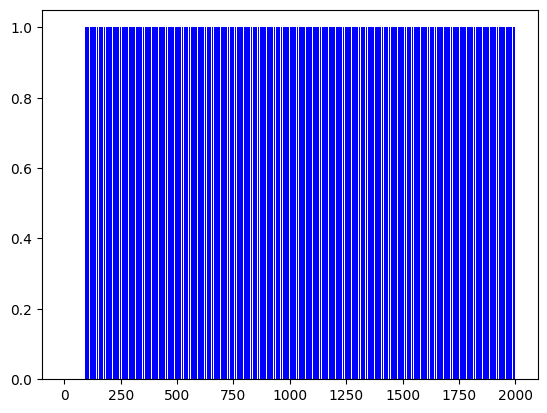

In [13]:
print('Success rate:' + str(sum(rList)/num_episodes))
print("final Q-Table Values")
print(Q) #left =0 ,down = 1 right = 2 up =3
plt.bar(range(len(rList)), rList,color='blue')
plt.show()

In [4]:
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque

# Define the Deep Q-Network (DQN) model
class DQN(nn.Module):
    def __init__(self, state_size, action_size):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(state_size, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, action_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x


class SnakeGame:
    def __init__(self, grid_size=10):
        self.grid_size = grid_size
        self.reset()

    def reset(self):
        self.snake_head = (random.randint(1, self.grid_size-2), random.randint(1, self.grid_size-2))
        self.snake_body = [self.snake_head]
        self.apple = self.generate_apple()
        self.score = 0
        self.game_over = False

    def generate_apple(self):
        while True:
            apple = (random.randint(1, self.grid_size-2), random.randint(1, self.grid_size-2))
            if apple not in self.snake_body:
                return apple
            
    def move_snake(self, action):
        direction = self.get_direction(action)
        new_head = (self.snake_head[0] + direction[0], self.snake_head[1] + direction[1])

        if (
            new_head[0] < 0 or new_head[0] >= self.grid_size or
            new_head[1] < 0 or new_head[1] >= self.grid_size or
            new_head in self.snake_body[1:]  # Check collision with body except the head
        ):
            print("Collision detected!")
            self.game_over = True
            return

        self.snake_body.insert(0, new_head)
        if new_head == self.apple:
            self.score += 1
            self.apple = self.generate_apple()
        else:
            self.snake_body.pop()

        self.snake_head = new_head


    def get_direction(self, action):
        if action == 0:  # Up
            return (-1, 0)
        elif action == 1:  # Down
            return (1, 0)
        elif action == 2:  # Left
            return (0, -1)
        elif action == 3:  # Right
            return (0, 1)

    def get_state(self):
        state = np.zeros((self.grid_size, self.grid_size))
        for i, j in self.snake_body:
            state[i, j] = 1
        state[self.apple] = 2
        return state


class DQNAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=2000)
        self.gamma = 0.95  # Discount factor
        self.epsilon = 1.0  # Exploration rate
        self.epsilon_decay = 0.995
        self.epsilon_min = 0.01
        self.learning_rate = 0.001
        self.model = DQN(state_size, action_size)
        self.optimizer = optim.Adam(self.model.parameters(), lr=self.learning_rate)

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randint(0, self.action_size-1)
        q_values = self.model(torch.tensor(state, dtype=torch.float32))
        return torch.argmax(q_values).item()

    def experience_replay(self, batch_size):
        if len(self.memory) < batch_size:
            return

        batch = random.sample(self.memory, batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)

        states = torch.tensor(states, dtype=torch.float32)
        actions = torch.tensor(actions, dtype=torch.long).unsqueeze(1)
        rewards = torch.tensor(rewards, dtype=torch.float32).unsqueeze(1)
        next_states = torch.tensor(next_states, dtype=torch.float32)
        dones = torch.tensor(dones, dtype=torch.float32).unsqueeze(1)

        q_values = self.model(states).gather(1, actions)
        next_q_values = self.model(next_states).max(1)[0].unsqueeze(1)
        target_q_values = rewards + self.gamma * next_q_values * (1 - dones)

        loss = nn.MSELoss()(q_values, target_q_values)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay


In [21]:
import pygame



game = SnakeGame(grid_size=10)
agent = DQNAgent(state_size=game.grid_size**2, action_size=4)

pygame.init()
window = pygame.display.set_mode((game.grid_size*30, game.grid_size*30))
clock = pygame.time.Clock()

running = True
while running:
    # Handle events
    for event in pygame.event.get():
        if event.type == pygame.QUIT:
            running = False

    # Get current game state
    state = game.get_state()

    # Choose action based on current state
    action = agent.act(state)

    # Move the snake and update game state
    game.move_snake(action)
    next_state = game.get_state()

    # Get reward and check if the game is over
    reward = game.score
    done = game.game_over

    # Store the experience in agent's memory
    agent.remember(state, action, reward, next_state, done)

    # Perform experience replay
    agent.experience_replay(batch_size=32)

    # Render the game
    window.fill((0, 0, 0))
    # Render the snake
    for i, j in game.snake_body:
        pygame.draw.rect(window, (255, 255, 255), (j*30, i*30, 30, 30))
    # Render the apple
    i, j = game.apple
    pygame.draw.rect(window, (255, 0, 0), (j*30, i*30, 30, 30))
    pygame.display.flip()

    # Delay for smooth rendering
    pygame.time.delay(100)

    # Check if the game is over
    if done:
        print(f"Game Over! Score: {game.score}")
        game.reset()


RuntimeError: mat1 and mat2 shapes cannot be multiplied (320x10 and 100x64)

In [72]:
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
import pygame

# Define the Deep Q-Network (DQN) model
class DQN(nn.Module):
    def __init__(self, state_size, action_size):
        super(DQN, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(state_size, 24),
            nn.ReLU(),
            nn.Linear(24, 24),
            nn.ReLU(),
            nn.Linear(24, action_size)
        )

    def forward(self, x):
        return self.model(x)


class SnakeGame:
    def __init__(self, grid_size=10):
        self.grid_size = grid_size
        self.reset()

    def reset(self):
        self.snake_head = (random.randint(1, self.grid_size-2), random.randint(1, self.grid_size-2))
        self.snake_body = [self.snake_head]
        self.apple = self.generate_apple()
        self.score = 0
        self.game_over = False

    def generate_apple(self):
        while True:
            apple = (random.randint(1, self.grid_size-2), random.randint(1, self.grid_size-2))
            if apple not in self.snake_body:
                return apple

    def move_snake(self, action):
        direction = self.get_direction(action)
        new_head = (self.snake_head[0] + direction[0], self.snake_head[1] + direction[1])

        if (
            new_head[0] < 0 or new_head[0] >= self.grid_size or
            new_head[1] < 0 or new_head[1] >= self.grid_size or
            new_head in self.snake_body
        ):
            self.game_over = True
            return

        self.snake_body.insert(0, new_head)
        if new_head == self.apple:
            self.score += 1
            self.apple = self.generate_apple()
        else:
            self.snake_body.pop()

        self.snake_head = new_head

    def get_direction(self, action):
        directions = [(-1, 0), (1, 0), (0, -1), (0, 1)]
        return directions[action]

    def get_state(self):
        state = np.zeros((1, self.grid_size**2))
        for i, j in self.snake_body:
            state[0, i*self.grid_size + j] = 1
        state[0, self.apple[0]*self.grid_size + self.apple[1]] = 2
        return state


class DQNAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=2000)
        self.gamma = 0.95  # Discount factor
        self.epsilon = 1.0  # Exploration rate
        self.epsilon_decay = 0.995
        self.epsilon_min = 0.01
        self.learning_rate = 0.001
        self.model = DQN(state_size, action_size)
        self.optimizer = optim.Adam(self.model.parameters(), lr=self.learning_rate)

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randint(0, self.action_size-1)
        q_values = self.model(torch.tensor(state, dtype=torch.float32))
        return torch.argmax(q_values).item()

    def experience_replay(self, batch_size):
        if len(self.memory) < batch_size:
            return

        batch = random.sample(self.memory, batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)

        states = torch.tensor(states, dtype=torch.float32)
        actions = torch.tensor(actions, dtype=torch.long).unsqueeze(1)
        rewards = torch.tensor(rewards, dtype=torch.float32).unsqueeze(1)
        next_states = torch.tensor(next_states, dtype=torch.float32)
        dones = torch.tensor(dones, dtype=torch.float32).unsqueeze(1)

        batch_size = states.shape[0]  # Get the actual batch size

        q_values = self.model(states.view(batch_size, -1)).gather(1, actions)
        next_q_values = self.model(next_states.view(batch_size, -1)).max(1)[0].unsqueeze(1)
        target_q_values = rewards + self.gamma * next_q_values * (1 - dones)

        loss = nn.MSELoss()(q_values, target_q_values)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay


# Initialize the game and the agent
game = SnakeGame(grid_size=10)
agent = DQNAgent(state_size=game.grid_size**2, action_size=4)

# Initialize Pygame
pygame.init()
window = pygame.display.set_mode((game.grid_size*30, game.grid_size*30))
clock = pygame.time.Clock()

running = True
count = 0
while running:
    # Handle events
    for event in pygame.event.get():
        if event.type == pygame.QUIT:
            running = False

    # Get current game state
    state = game.get_state()

    # Choose action based on current state
    action = agent.act(state)

    # Move the snake and update game state
    game.move_snake(action)
    next_state = game.get_state()

    # Get reward and check if the game is over
    reward = game.score
    done = game.game_over

    # Store the experience in agent's memory
    agent.remember(state, action, reward, next_state, done)

    # Perform experience replay
    agent.experience_replay(batch_size=200)

    # Render the game
    window.fill((0, 0, 0))
    # Render the snake
    for i, j in game.snake_body:
        pygame.draw.rect(window, (255, 255, 255), (j*30, i*30, 30, 30))
    # Render the apple
    i, j = game.apple
    pygame.draw.rect(window, (255, 0, 0), (j*30, i*30, 30, 30))
    pygame.display.flip()

    # Delay for smooth rendering
    pygame.time.delay(100)

    # Check if the game is over
    if done:
        count += 1
        print(f"{count}Game Over! Score: {game.score}")
        game.reset()

pygame.quit()


1Game Over! Score: 0
2Game Over! Score: 0
3Game Over! Score: 0
4Game Over! Score: 0
5Game Over! Score: 0
6Game Over! Score: 1
7Game Over! Score: 0
8Game Over! Score: 0
9Game Over! Score: 0
10Game Over! Score: 0
11Game Over! Score: 0
12Game Over! Score: 0
13Game Over! Score: 0
14Game Over! Score: 0
15Game Over! Score: 0
16Game Over! Score: 0
17Game Over! Score: 0
18Game Over! Score: 0
19Game Over! Score: 0
20Game Over! Score: 1
21Game Over! Score: 0
22Game Over! Score: 0
23Game Over! Score: 0
24Game Over! Score: 0
25Game Over! Score: 0
26Game Over! Score: 0
27Game Over! Score: 0
28Game Over! Score: 1
29Game Over! Score: 0
30Game Over! Score: 1
31Game Over! Score: 0
32Game Over! Score: 0
33Game Over! Score: 0
34Game Over! Score: 0
35Game Over! Score: 0
36Game Over! Score: 0
37Game Over! Score: 0
38Game Over! Score: 0
39Game Over! Score: 0
40Game Over! Score: 0
41Game Over! Score: 0
42Game Over! Score: 1
43Game Over! Score: 0
44Game Over! Score: 0
45Game Over! Score: 0
46Game Over! Score:

KeyboardInterrupt: 

In [50]:
test=random.sample(agent.memory, batch_size)

In [53]:
states, actions, rewards, next_states, dones = zip(*test)

In [54]:
states

(array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 2., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]),
 array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 2., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]

In [56]:
states = torch.tensor(states, dtype=torch.float32)
actions = torch.tensor(actions, dtype=torch.long).unsqueeze(1)
q_values = agent.model(states).gather(1, actions)

RuntimeError: mat1 and mat2 shapes cannot be multiplied (320x10 and 100x24)

In [58]:
states.shape

torch.Size([32, 10, 10])

In [64]:
agent.model

DQN(
  (model): Sequential(
    (0): Linear(in_features=100, out_features=24, bias=True)
    (1): ReLU()
    (2): Linear(in_features=24, out_features=24, bias=True)
    (3): ReLU()
    (4): Linear(in_features=24, out_features=4, bias=True)
  )
)

In [61]:
agent.model(states)

RuntimeError: mat1 and mat2 shapes cannot be multiplied (320x10 and 100x24)

In [60]:
actions.shape

torch.Size([32, 1])

In [37]:
d

1

In [38]:
new_state

15

KeyboardInterrupt: 

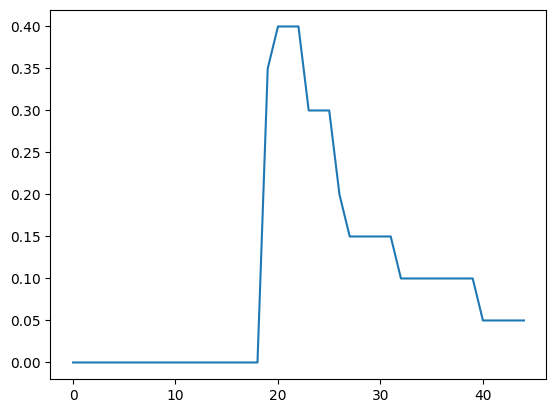

In [11]:
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
import pygame
import matplotlib.pyplot as plt
import matplotlib
from IPython.display import clear_output
# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display
plt.ion()

# Define the Deep Q-Network (DQN) model
class DQN(nn.Module):
    def __init__(self, state_size, action_size):
        super(DQN, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(state_size, 24),
            nn.ReLU(),
            nn.Linear(24, 24),
            nn.ReLU(),
            nn.Linear(24, action_size)
        )

    def forward(self, x):
        return self.model(x)


class SnakeGame:
    def __init__(self, grid_size=10):
        self.grid_size = grid_size
        self.reset()

    def reset(self):
        self.snake_head = (random.randint(1, self.grid_size-2), random.randint(1, self.grid_size-2))
        self.snake_body = [self.snake_head]
        self.apple = self.generate_apple()
        self.score = 0
        self.game_over = False

    def generate_apple(self):
        while True:
            apple = (random.randint(1, self.grid_size-2), random.randint(1, self.grid_size-2))
            if apple not in self.snake_body:
                return apple

    def move_snake(self, action):
        direction = self.get_direction(action)
        new_head = (self.snake_head[0] + direction[0], self.snake_head[1] + direction[1])

        if (
            new_head[0] < 0 or new_head[0] >= self.grid_size or
            new_head[1] < 0 or new_head[1] >= self.grid_size or
            new_head in self.snake_body[0:-1]  # Check collision with body except the last segment
        ):
            print("Collision detected!")
            self.game_over = True
            return

        self.snake_body.insert(0, new_head)
        if new_head == self.apple:
            self.score += 1
            self.apple = self.generate_apple()
        else:
            self.snake_body.pop()

        self.snake_head = new_head


    def get_direction(self, action):
        directions = [(-1, 0), (1, 0), (0, -1), (0, 1)]
        return directions[action]

    def get_state(self):
        state = np.zeros((1, self.grid_size**2))
        for i, j in self.snake_body:
            state[0, i*self.grid_size + j] = 1
        state[0, self.apple[0]*self.grid_size + self.apple[1]] = 2
        return state


class DQNAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=2000)
        self.gamma = 0.95  # Discount factor
        self.epsilon = 1.0  # Exploration rate
        self.epsilon_decay = 0.995
        self.epsilon_min = 0.01
        self.learning_rate = 0.001
        self.model = DQN(state_size, action_size)
        self.optimizer = optim.Adam(self.model.parameters(), lr=self.learning_rate)

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randint(0, self.action_size-1)
        q_values = self.model(torch.tensor(state, dtype=torch.float32))
        return torch.argmax(q_values).item()

    def experience_replay(self, batch_size):
        if len(self.memory) < batch_size:
            return

        batch = random.sample(self.memory, batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)

        states = torch.tensor(states, dtype=torch.float32)
        actions = torch.tensor(actions, dtype=torch.long).unsqueeze(1)
        rewards = torch.tensor(rewards, dtype=torch.float32).unsqueeze(1)
        next_states = torch.tensor(next_states, dtype=torch.float32)
        dones = torch.tensor(dones, dtype=torch.float32).unsqueeze(1)

        batch_size = states.shape[0]  # Get the actual batch size

        q_values = self.model(states.view(batch_size, -1)).gather(1, actions)
        next_q_values = self.model(next_states.view(batch_size, -1)).max(1)[0].unsqueeze(1)
        target_q_values = rewards + self.gamma * next_q_values * (1 - dones)

        loss = nn.MSELoss()(q_values, target_q_values)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay


# Define the plot_durations function
# Define the plot_durations function
def plot_durations(scores,show_result = False): 
    plt.figure(1)   
    if show_result:
        plt.title('Result')
    else:
        plt.clf()
        plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Score')
    plt.title('Snake Game Scores')
    plt.plot(scores)
    plt.pause(0.001)  # pause a bit so that plots are updated
    if len(scores) >= 20:
        scores = torch.tensor(scores, dtype=torch.float32)
        means = scores.unfold(0, 20, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(19), means))
        plt.plot(means.numpy())
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())


# Initialize the game and the agent
game = SnakeGame(grid_size=10)
agent = DQNAgent(state_size=game.grid_size**2, action_size=4)

# Initialize Pygame
pygame.init()
window = pygame.display.set_mode((game.grid_size*30, game.grid_size*30))
clock = pygame.time.Clock()


count = 0
scores = []  # List to store the scores

running = True

while running:
    # Handle events
    for event in pygame.event.get():
        if event.type == pygame.QUIT:
            running = False

    # Get current game state
    state = game.get_state()

    # Choose action based on current state
    action = agent.act(state)

    # Move the snake and update game state
    game.move_snake(action)
    next_state = game.get_state()

    # Get reward and check if the game is over
    reward = game.score
    done = game.game_over

    # Store the experience in agent's memory
    agent.remember(state, action, reward, next_state, done)

    # Perform experience replay
    agent.experience_replay(batch_size=200)

    # Render the game
    window.fill((0, 0, 0))
    # Render the snake
    for i, j in game.snake_body:
        pygame.draw.rect(window, (255, 255, 255), (j*30, i*30, 30, 30))
    # Render the apple
    i, j = game.apple
    pygame.draw.rect(window, (255, 0, 0), (j*30, i*30, 30, 30))
    pygame.display.flip()

    # Delay for smooth rendering
    pygame.time.delay(100)

    # Check if the game is over
    if done:
        count += 1
        scores.append(game.score)
        game.reset()

        # Call the plot_durations function here passing the scores list
        plot_durations(scores)

pygame.quit()


KeyboardInterrupt: 

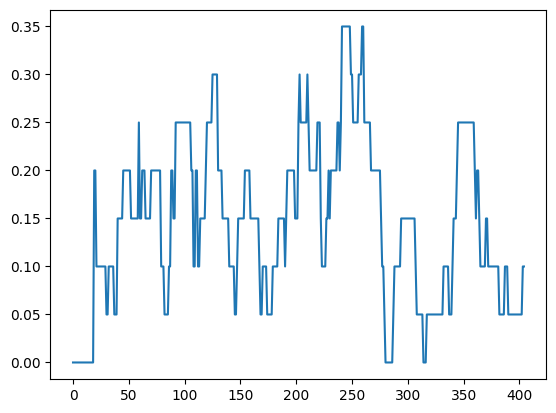

In [13]:
#gpu
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
import pygame
import matplotlib.pyplot as plt
import matplotlib
from IPython.display import clear_output

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display
plt.ion()

# Define the Deep Q-Network (DQN) model
class DQN(nn.Module):
    def __init__(self, state_size, action_size):
        super(DQN, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(state_size, 24),
            nn.ReLU(),
            nn.Linear(24, 24),
            nn.ReLU(),
            nn.Linear(24, action_size)
        )

    def forward(self, x):
        return self.model(x)


class SnakeGame:
    def __init__(self, grid_size=10):
        self.grid_size = grid_size
        self.reset()

    def reset(self):
        self.snake_head = (random.randint(1, self.grid_size-2), random.randint(1, self.grid_size-2))
        self.snake_body = [self.snake_head]
        self.apple = self.generate_apple()
        self.score = 0
        self.game_over = False

    def generate_apple(self):
        while True:
            apple = (random.randint(1, self.grid_size-2), random.randint(1, self.grid_size-2))
            if apple not in self.snake_body:
                return apple

    def move_snake(self, action):
        direction = self.get_direction(action)
        new_head = (self.snake_head[0] + direction[0], self.snake_head[1] + direction[1])

        if (
            new_head[0] < 0 or new_head[0] >= self.grid_size or
            new_head[1] < 0 or new_head[1] >= self.grid_size or
            new_head in self.snake_body[0:-1]  # Check collision with body except the last segment
        ):
            print("Collision detected!")
            self.game_over = True
            return

        self.snake_body.insert(0, new_head)
        if new_head == self.apple:
            self.score += 1
            self.apple = self.generate_apple()
        else:
            self.snake_body.pop()

        self.snake_head = new_head


    def get_direction(self, action):
        directions = [(-1, 0), (1, 0), (0, -1), (0, 1)]
        return directions[action]

    def get_state(self):
        state = np.zeros((1, self.grid_size**2))
        for i, j in self.snake_body:
            state[0, i*self.grid_size + j] = 1
        state[0, self.apple[0]*self.grid_size + self.apple[1]] = 2
        return state


class DQNAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=2000)
        self.gamma = 0.95  # Discount factor
        self.epsilon = 1.0  # Exploration rate
        self.epsilon_decay = 0.995
        self.epsilon_min = 0.4
        self.learning_rate = 0.001
        self.model = DQN(state_size, action_size).to(device)
        self.optimizer = optim.Adam(self.model.parameters(), lr=self.learning_rate)

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randint(0, self.action_size-1)
        q_values = self.model(torch.tensor(state, dtype=torch.float32).to(device))
        return torch.argmax(q_values).item()

    def experience_replay(self, batch_size):
        if len(self.memory) < batch_size:
            return

        batch = random.sample(self.memory, batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)

        states = torch.tensor(states, dtype=torch.float32).to(device)
        actions = torch.tensor(actions, dtype=torch.long).unsqueeze(1).to(device)
        rewards = torch.tensor(rewards, dtype=torch.float32).unsqueeze(1).to(device)
        next_states = torch.tensor(next_states, dtype=torch.float32).to(device)
        dones = torch.tensor(dones, dtype=torch.float32).unsqueeze(1).to(device)

        batch_size = states.shape[0]  # Get the actual batch size

        q_values = self.model(states.view(batch_size, -1)).gather(1, actions)
        next_q_values = self.model(next_states.view(batch_size, -1)).max(1)[0].unsqueeze(1)
        target_q_values = rewards + self.gamma * next_q_values * (1 - dones)

        loss = nn.MSELoss()(q_values, target_q_values)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay


# Define the plot_durations function
def plot_durations(scores, show_result=False): 
    plt.figure(1)   
    if show_result:
        plt.title('Result')
    else:
        plt.clf()
        plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Score')
    plt.title('Snake Game Scores')
    plt.plot(scores)
    plt.pause(0.001)  # pause a bit so that plots are updated
    if len(scores) >= 20:
        scores = torch.tensor(scores, dtype=torch.float32)
        means = scores.unfold(0, 20, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(19), means))
        plt.plot(means.cpu().numpy())
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())


# Initialize the game and the agent
game = SnakeGame(grid_size=10)
agent = DQNAgent(state_size=game.grid_size**2, action_size=4)

# Move the model to GPU
agent.model.to(device)

# Initialize Pygame
pygame.init()
window = pygame.display.set_mode((game.grid_size*30, game.grid_size*30))
clock = pygame.time.Clock()


count = 0
scores = []  # List to store the scores

running = True

while running:
    # Handle events
    for event in pygame.event.get():
        if event.type == pygame.QUIT:
            running = False

    # Get current game state
    state = game.get_state()

    # Choose action based on current state
    action = agent.act(state)

    # Move the snake and update game state
    game.move_snake(action)
    next_state = game.get_state()

    # Get reward and check if the game is over
    reward = game.score
    done = game.game_over

    # Store the experience in agent's memory
    agent.remember(state, action, reward, next_state, done)

    # Perform experience replay
    agent.experience_replay(batch_size=200)

    # Render the game
    window.fill((0, 0, 0))
    # Render the snake
    for i, j in game.snake_body:
        pygame.draw.rect(window, (255, 255, 255), (j*30, i*30, 30, 30))
    # Render the apple
    i, j = game.apple
    pygame.draw.rect(window, (255, 0, 0), (j*30, i*30, 30, 30))
    pygame.display.flip()

    # Delay for smooth rendering
    pygame.time.delay(100)

    # Check if the game is over
    if done:
        count += 1
        scores.append(game.score)
        game.reset()

        # Call the plot_durations function here passing the scores list
        plot_durations(scores)

pygame.quit()


In [14]:
pygame.quit()

KeyboardInterrupt: 

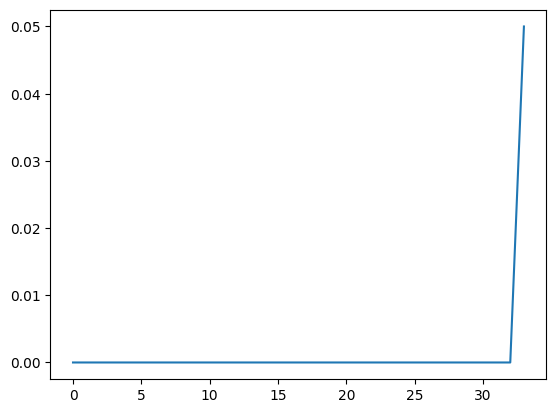

In [15]:
#gpu
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
import pygame
import matplotlib.pyplot as plt
import matplotlib
from IPython.display import clear_output

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display
plt.ion()

# Define the Deep Q-Network (DQN) model
class DQN(nn.Module):
    def __init__(self, state_size, action_size):
        super(DQN, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(state_size, 24),
            nn.ReLU(),
            nn.Linear(24, 24),
            nn.ReLU(),
            nn.Linear(24, action_size)
        )

    def forward(self, x):
        return self.model(x)


class SnakeGame:
    def __init__(self, grid_size=10):
        self.grid_size = grid_size
        self.reset()

    def reset(self):
        self.snake_head = (random.randint(1, self.grid_size-2), random.randint(1, self.grid_size-2))
        self.snake_body = [self.snake_head]
        self.apple = self.generate_apple()
        self.score = 0
        self.game_over = False

    def generate_apple(self):
        while True:
            apple = (random.randint(1, self.grid_size-2), random.randint(1, self.grid_size-2))
            if apple not in self.snake_body:
                return apple

    def move_snake(self, action):
        direction = self.get_direction(action)
        new_head = (self.snake_head[0] + direction[0], self.snake_head[1] + direction[1])

        if (
            new_head[0] < 0 or new_head[0] >= self.grid_size or
            new_head[1] < 0 or new_head[1] >= self.grid_size or
            new_head in self.snake_body[0:-1]  # Check collision with body except the last segment
        ):
            print("Collision detected!")
            self.game_over = True
            return

        self.snake_body.insert(0, new_head)
        if new_head == self.apple:
            self.score += 1
            self.apple = self.generate_apple()
        else:
            self.snake_body.pop()

        self.snake_head = new_head


    def get_direction(self, action):
        directions = [(-1, 0), (1, 0), (0, -1), (0, 1)]
        return directions[action]

    def get_state(self):
        state = np.zeros((1, self.grid_size**2))
        for i, j in self.snake_body:
            state[0, i*self.grid_size + j] = 1
        state[0, self.apple[0]*self.grid_size + self.apple[1]] = 2
        return state


class DQNAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=2000)
        self.gamma = 0.95  # Discount factor
        self.epsilon = 1.0  # Exploration rate
        self.epsilon_decay = 0.995
        self.epsilon_min = 0.2
        self.learning_rate = 0.001
        self.model = DQN(state_size, action_size).to(device)
        self.optimizer = optim.Adam(self.model.parameters(), lr=self.learning_rate)

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randint(0, self.action_size-1)
        q_values = self.model(torch.tensor(state, dtype=torch.float32).to(device))
        return torch.argmax(q_values).item()

    def experience_replay(self, batch_size):
        if len(self.memory) < batch_size:
            return

        batch = random.sample(self.memory, batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)

        states = torch.tensor(states, dtype=torch.float32).to(device)
        actions = torch.tensor(actions, dtype=torch.long).unsqueeze(1).to(device)
        rewards = torch.tensor(rewards, dtype=torch.float32).unsqueeze(1).to(device)
        next_states = torch.tensor(next_states, dtype=torch.float32).to(device)
        dones = torch.tensor(dones, dtype=torch.float32).unsqueeze(1).to(device)

        batch_size = states.shape[0]  # Get the actual batch size

        q_values = self.model(states.view(batch_size, -1)).gather(1, actions)
        next_q_values = self.model(next_states.view(batch_size, -1)).max(1)[0].unsqueeze(1)
        target_q_values = rewards + self.gamma * next_q_values * (1 - dones)

        loss = nn.MSELoss()(q_values, target_q_values)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay


# Define the plot_durations function
def plot_durations(scores, show_result=False): 
    plt.figure(1)
    plt.figure(figsize=(10, 6))  # Adjust the figure size

    if show_result:
        plt.title('Result')
    else:
        plt.clf()
        plt.title('Training...')

    plt.xlabel('Episode')
    plt.ylabel('Score')
    plt.title('Snake Game Scores')
    plt.plot(scores)
    plt.pause(0.001)  # pause a bit so that plots are updated
    if len(scores) >= 20:
        scores = torch.tensor(scores, dtype=torch.float32)
        means = scores.unfold(0, 20, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(19), means))
        plt.plot(means.cpu().numpy())
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())


# Initialize the game and the agent
game = SnakeGame(grid_size=15)  # Increase grid size for larger window
agent = DQNAgent(state_size=game.grid_size**2, action_size=4)

# Move the model to GPU
agent.model.to(device)

# Initialize Pygame
pygame.init()
window = pygame.display.set_mode((game.grid_size*40, game.grid_size*40))  # Increase size for larger window
clock = pygame.time.Clock()


count = 0
scores = []  # List to store the scores

running = True

while running:
    # Handle events
    for event in pygame.event.get():
        if event.type == pygame.QUIT:
            running = False

    # Get current game state
    state = game.get_state()

    # Choose action based on current state
    action = agent.act(state)

    # Move the snake and update game state
    game.move_snake(action)
    next_state = game.get_state()

    # Get reward and check if the game is over
    reward = game.score
    done = game.game_over

    # Store the experience in agent's memory
    agent.remember(state, action, reward, next_state, done)

    # Perform experience replay
    agent.experience_replay(batch_size=200)

    # Render the game
    window.fill((0, 0, 0))
    # Render the snake
    for i, j in game.snake_body:
        pygame.draw.rect(window, (255, 255, 255), (j*40, i*40, 40, 40))  # Increase size for larger window
    # Render the apple
    i, j = game.apple
    pygame.draw.rect(window, (255, 0, 0), (j*40, i*40, 40, 40))  # Increase size for larger window
    pygame.display.flip()

    # Delay for smooth rendering
    pygame.time.delay(1)

    # Check if the game is over
    if done:
        count += 1
        scores.append(game.score)
        game.reset()

        # Call the plot_durations function here passing the scores list
        plot_durations(scores)

pygame.quit()
